# ISLR- Python: Ch7 Applied 4

- [Import Boston Dataset](#Import-Boston-Dataset)
- [Cubic Regression of Dis onto Nox](#Cubic-Regression-of Dis-onto-Nox)
- [Plot a Range of Polynomials of Dis onto Nox](#Plot-a-Range-of-Polynomials-of-Dis-onto-Nox)
- [Cross Validation](#Cross-Validation)
- [Basis Spline Fits](#Basis-Spline-Fits)
- [Cross Validation](#Cross-Validation)

In [126]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from patsy import bs, dmatrix
from matplotlib.pyplot import cm 
from matplotlib import pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

## Import Boston Dataset

In [2]:
boston = pd.read_csv('../../../data/Boston.csv', index_col=0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Cubic Regression of Dis onto Nox

rss = 1.93410670718


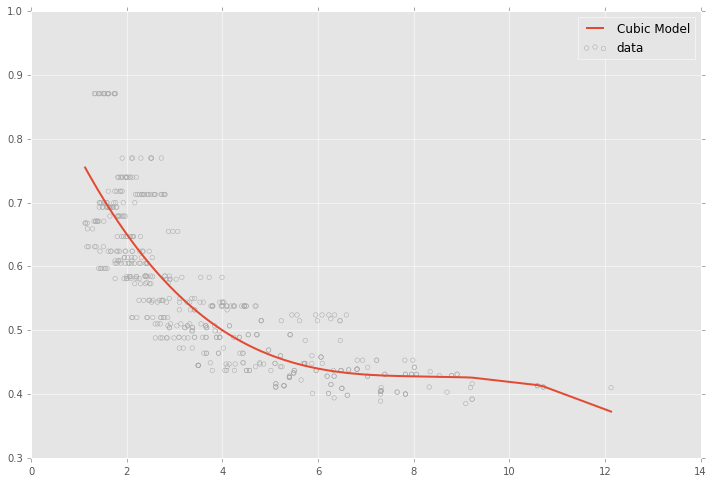

In [160]:
# Get predictors and response
X = boston.dis.values.reshape(-1,1)
y = boston.nox.values.reshape(-1,1)

# generate the polynomial
poly = PolynomialFeatures(degree=3, include_bias=True)
design = poly.fit_transform(X)

# Fit cubic model
lm = LinearRegression(fit_intercept=False)
cubic_est = lm.fit(design, y)

# make in-sample predictons with cubic estimate
order = np.argsort(X, axis=0).flatten()
y_pred = cubic_est.predict(design)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.scatter(X,y, label='data', facecolor='none', edgecolor = 'darkgray');
ax.plot(X[order], y_pred[order], lw=2, label='Cubic Model');
ax.legend(loc='best');

rss = np.sum((y_pred-y)**2)
print('rss =', rss)

## Plot a Range of Polynomials of Dis onto Nox

No we will perform a regression using polynomials of several orders and report the RSS.

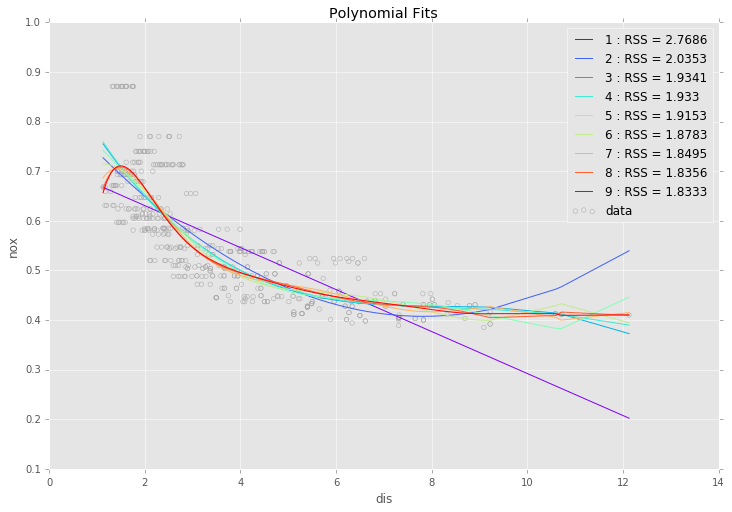

In [155]:
# Define the orders
orders = list(np.arange(1,10))

# Create the plot and add the data
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.scatter(X,y, label='data', facecolor='none', edgecolor = 'darkgray');
# get the index of the order of the data
idx = np.argsort(X, axis=0).flatten() 
# create a colormap so we can distinguish diff order polys
colors = iter(cm.rainbow(np.linspace(0, 1, len(orders))))

for order in orders:
    # construct a polynomial of this order
    poly = PolynomialFeatures(degree=order, include_bias=True)
    design = poly.fit_transform(X)
    
    # fit model of this order
    lm = LinearRegression(fit_intercept=False)
    poly_est = lm.fit(design, y)

    # make in-sample predictons with poly estimate
    y_pred = poly_est.predict(design)
    
    # compute the RSS
    rss = np.round(np.sum((y_pred-y)**2),4)
    
    # add to the plot
    ax.plot(X[idx], y_pred[idx], color=next(colors), label=str(order )+' : '+ 'RSS = '+str(rss));
    ax.legend(loc='best');
    ax.set_xlabel('dis')
    ax.set_ylabel('nox')
plt.title('Polynomial Fits');

No suprise as the degree of the polynomial increase the flexibility of the model increases and the RSS falls. This is why it is crucial to evaluate a model's performance on a test set. That's what we will do next...

## Cross Validation 

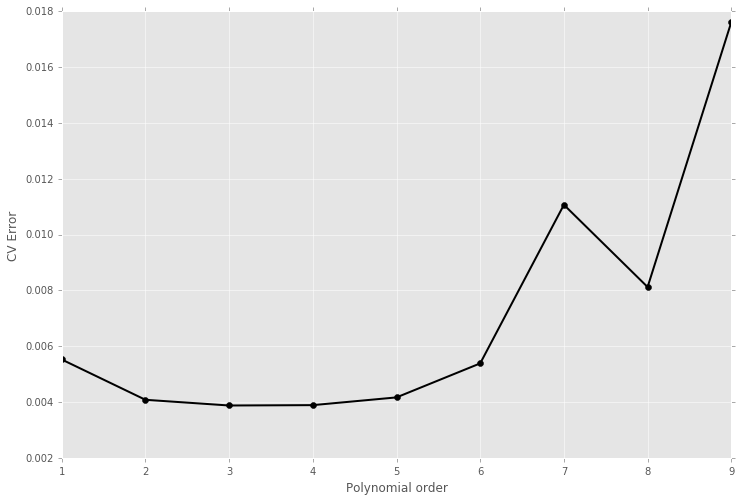

In [123]:
scores = np.array([])

for order in orders:
    # construct a polynomial of this order
    poly = PolynomialFeatures(degree=order, include_bias=True)
    design = poly.fit_transform(X)
    # construct a model and compute cross-val score
    lm = LinearRegression(fit_intercept=False)
    # Perform CV
    scores = np.append(scores, -np.mean(cross_val_score(lm, design, y, cv=len(design), 
                                                        scoring='mean_squared_error')))
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(orders, scores, lw=2, color='k', marker='o');
ax.set_xlabel('Polynomial order');
ax.set_ylabel('CV Error');

The minimum is aroud a 3 or 4 degree polynomial.

## Basis Spline Fits

Fit a single cubic basis spline with 4 degrees of freedom and the knots will be chosen automatically at the quantiles of the data.

In [137]:
# create a bspline design matrix with patsy
design = dmatrix('1 + bs(dis, df=4)', data={'dis':boston.dis}, return_type='matrix')
# create a linear model
lm = LinearRegression(fit_intercept=False)
# and fit
estimate = lm.fit(design,y)

# make in-sample predictions
y_pred = estimate.predict(design)
# compute the RSS
rss = np.sum((y_pred-y)**2)
print('Model RSS for dof=4 is ',rss)

Model RSS for dof=4 is  1.92277499281


Now we will fit basis splines of varying dof.

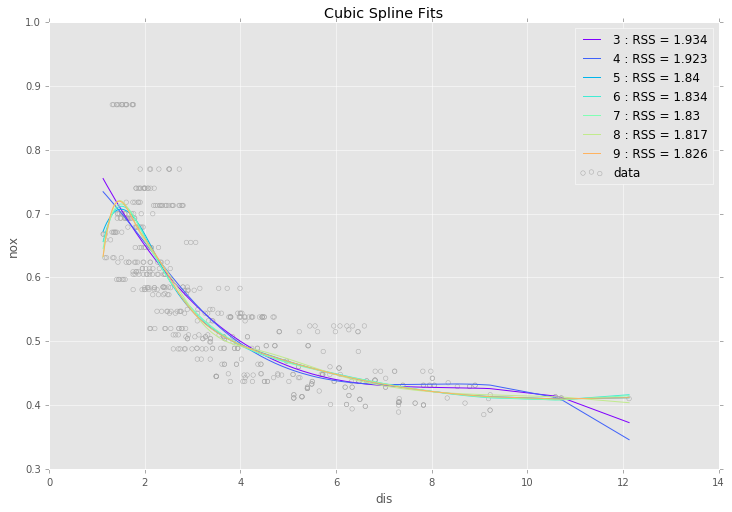

In [152]:
# Create the plot and add the data
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.scatter(X,y, label='data', facecolor='none', edgecolor = 'darkgray');
# get the index of the order of the data
idx = np.argsort(X, axis=0).flatten() 
# create a colormap so we can distinguish diff order polys
colors = iter(cm.rainbow(np.linspace(0, 1, len(orders))))

# The degrees of freedom for a bspline are dof=k+4 where k is the knots. In patsy, the dof=k+3 so at minimum we 
# can have 3 dofs
dofs = list(range(3,10))

for dof in dofs:
    #build a design matrix for this dof
    formula = '1 + bs(dis, df=%d)' %(dof)
    X_basis = dmatrix(formula, data={'dis':boston.dis}, return_type='matrix')
    
    # fit model of this order
    lm = LinearRegression(fit_intercept=False)
    poly_est = lm.fit(X_basis, y)

    # make in-sample predictons with poly estimate
    y_pred = poly_est.predict(X_basis)
    
    # compute the RSS
    rss = np.round(np.sum((y_pred-y)**2),3)
    
    # add to the plot
    ax.plot(X[idx], y_pred[idx], color=next(colors), label=str(dof)+' : '+ 'RSS = '+str(rss));
    ax.set_xlabel('dis')
    ax.set_ylabel('nox')
    ax.legend(loc='best')
    plt.title('Cubic Spline Fits')
      

Again decreasing RSS as the dof increases due to increased model flexibility.

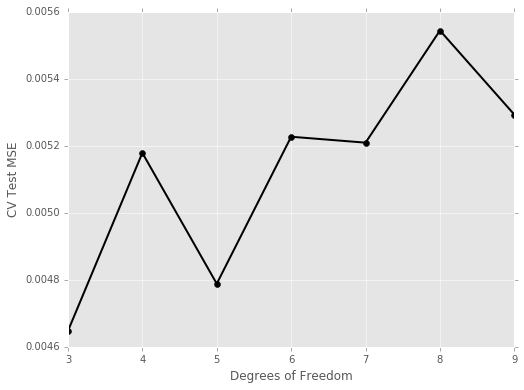

In [157]:
def basis_spline_cv(predictor, response, dofs=list(np.arange(3,10)), kfolds=5):
    """
    Returns an sklearn LinearRegression model object of a spline regression of predictor(pd.Series) onto response 
    (pd.Series). Uses kfold cross-validation and returns a plot to aid in degree selection.
    """
    # cross-val scores- array[dof]
    scores = np.array([])
    X_basis = np.array([])
    
    for dof in dofs:
        # natural spline dmatrix
        formula = r'1 + bs(predictor, df=dof)'
        X_basis = dmatrix(formula, data={'predictor':predictor}, return_type='matrix')
     
        # model
        estimator = LinearRegression(fit_intercept=False)
        # cross-validation
        scores = np.append(scores, -np.mean(cross_val_score(estimator, X_basis, response, 
                                                            scoring='mean_squared_error', cv=kfolds)))
    # Build CV Error plot
    fig,ax = plt.subplots(1,1, figsize=(8,6))
    ax.plot(dofs, scores, lw=2, color='k', marker='o')
    ax.set_xlabel('Degrees of Freedom')
    ax.set_ylabel('CV Test MSE')
        
basis_spline_cv(boston.dis, boston.nox)

The Cross-validation suggest a basis spline of 3 degrees of freedom. This would correspond to no interior knots and matches with the polynomial of order 3 results above.